<a href="https://colab.research.google.com/github/shivgarg/image-superresolution/blob/master/Perceptual_loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch.nn as nn
import torch.nn.functional as F
import torch
from torchvision.models import vgg19
import math
import glob
import random
import os
import numpy as np
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms

import argparse
import os
import numpy as np
import math
import itertools
import sys
import ssim

import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid

from torch.utils.data import DataLoader
from torch.autograd import Variable



import torch.nn as nn
import torch.nn.functional as F
import torch
%matplotlib inline

class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        vgg19_model = vgg19(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(vgg19_model.features.children())[:18])

    def forward(self, img):
        return self.feature_extractor(img)


class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_features),
            nn.ReLU(),
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_features),
            nn.ReLU()
        )
        

    def forward(self, x):
        return self.conv_block(x)


class GeneratorResNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, n_residual_blocks=16):
        super(GeneratorResNet, self).__init__()

        # First layer
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels, 128, kernel_size=3, stride=1, padding=1), nn.ReLU())
        
        # Residual blocks
        self.res_blocks1= ResidualBlock(128)

        # Upsampling layers
        self.upsampling0 = nn.Sequential(nn.Upsample(scale_factor=2),
                                          nn.Conv2d(128,64,3,1,1),
                                          nn.ReLU())
        self.res_block3 = ResidualBlock(64)    
    
        self.upsampling1 = nn.Sequential(nn.Upsample(scale_factor=2),
                                          nn.Conv2d(64,64,3,1,1),
                                          nn.ReLU())
        self.res_block4 = ResidualBlock(64)    
    
        # Final output layer
        self.conv7 = nn.Sequential(nn.Conv2d(64, out_channels, kernel_size=3, stride=1, padding=1), nn.ReLU())

    def forward(self, x):
        out1 = self.conv1(x)
        out2 = self.res_blocks1(out1)
        out1 = torch.add(out1,out2)
        
        out2 = self.upsampling0(out1)
        out = self.res_block3(out2)
        out1 = torch.add(out, out2)
        out2 = self.upsampling1(out1)
        out = self.res_block4(out2)
        out1 = torch.add(out, out2)
        out = self.conv7(out1)
        return out

# Normalization parameters for pre-trained PyTorch models
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])


class ImageDataset(Dataset):
    def __init__(self, root, hr_shape):
        hr_height, hr_width = hr_shape
        # Transforms for low resolution images and high resolution images
        self.lr_transform = transforms.Compose(
            [
                transforms.Resize((hr_height // 4, hr_height // 4)),
                transforms.ToTensor(),
                #transforms.Normalize(mean, std),
            ]
        )
        self.hr_transform = transforms.Compose(
            [
                transforms.Resize((hr_height, hr_height)),
                transforms.ToTensor(),
                #transforms.Normalize(mean, std),
            ]
        )
        
        self.hr_transform_norm = transforms.Compose(
            [
                transforms.Resize((hr_height, hr_height)),
                transforms.ToTensor(),
                transforms.Normalize(mean, std),
            ]
        )

        self.files = sorted(glob.glob(root + "/*.*"))

    def __getitem__(self, index):
        img = Image.open(self.files[index % len(self.files)])
        img_lr = self.lr_transform(img)
        img_hr = self.hr_transform(img)
        img_hr_norm = self.hr_transform_norm(img)
        return {"lr": img_lr, "hr": img_hr, "hr_norm": img_hr_norm}

    def __len__(self):
        return len(self.files)

In [0]:
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!unzip -q /content/drive/My\ Drive/DL/256x256.zip -d /data

replace /data/256x256/000000271402.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [0]:

cuda = torch.cuda.is_available()

In [0]:
hr_shape = (256, 256)

# Initialize generator and discriminator
generator = GeneratorResNet()
feature_extractor = FeatureExtractor()
# Set feature extractor to inference mode
feature_extractor.eval()

# Losses
criterion_L2 = torch.nn.MSELoss(reduction='mean')
criterion_L1 = torch.nn.L1Loss(reduction='mean')
criterion_SSIM = ssim.SSIM()

if cuda:
    generator = generator.cuda()
    criterion_L2 = criterion_L2.cuda()
    criterion_SSIM = criterion_SSIM.cuda()
    criterion_L1 = criterion_L1.cuda()
    feature_extractor = feature_extractor.cuda()

# Load pretrained models
# generator.load_state_dict(torch.load("saved_models/generator_%d.pth"))

# Optimizers

lr = 1e-4
weight_decay=1e-6
batch_size = 24
epochs = 200
checkpoint_interval = 1

optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr)
#optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

dataloader = DataLoader(
    ImageDataset("/data/256x256", hr_shape=hr_shape),
    batch_size=batch_size,
    shuffle=True,
    num_workers=4
)

[Epoch 0/200] [Batch 0/1563]  [G loss: -0.655837] [L1 loss: 0.041600] [l2 loss: 0.005013] [SSIM: -0.702450]


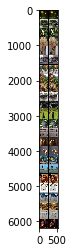

[Epoch 0/200] [Batch 200/1563]  [G loss: -0.706046] [L1 loss: 0.038562] [l2 loss: 0.004835] [SSIM: -0.749442]


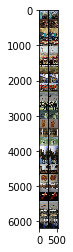

[Epoch 0/200] [Batch 400/1563]  [G loss: -0.709966] [L1 loss: 0.037968] [l2 loss: 0.004719] [SSIM: -0.752652]


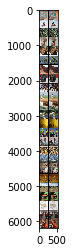

[Epoch 0/200] [Batch 600/1563]  [G loss: -0.709685] [L1 loss: 0.038239] [l2 loss: 0.004752] [SSIM: -0.752676]


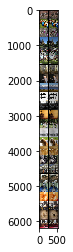

[Epoch 0/200] [Batch 800/1563]  [G loss: -0.708274] [L1 loss: 0.038277] [l2 loss: 0.004726] [SSIM: -0.751277]


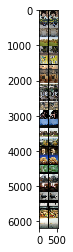

[Epoch 0/200] [Batch 1000/1563]  [G loss: -0.709751] [L1 loss: 0.037953] [l2 loss: 0.004693] [SSIM: -0.752396]


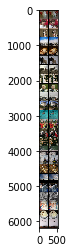

[Epoch 0/200] [Batch 1200/1563]  [G loss: -0.712212] [L1 loss: 0.037871] [l2 loss: 0.004698] [SSIM: -0.754780]


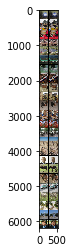

[Epoch 0/200] [Batch 1400/1563]  [G loss: -0.705766] [L1 loss: 0.038673] [l2 loss: 0.004901] [SSIM: -0.749340]


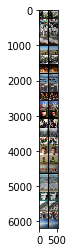

[Epoch 1/200] [Batch 37/1563]  [G loss: -0.698326] [L1 loss: 0.039635] [l2 loss: 0.004970] [SSIM: -0.742932]


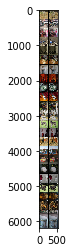

[Epoch 1/200] [Batch 237/1563]  [G loss: -0.708036] [L1 loss: 0.038460] [l2 loss: 0.004758] [SSIM: -0.751253]


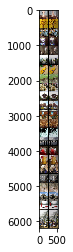

[Epoch 1/200] [Batch 437/1563]  [G loss: -0.711104] [L1 loss: 0.037862] [l2 loss: 0.004681] [SSIM: -0.753647]


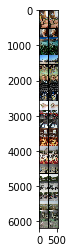

[Epoch 1/200] [Batch 637/1563]  [G loss: -0.708065] [L1 loss: 0.038488] [l2 loss: 0.004818] [SSIM: -0.751371]


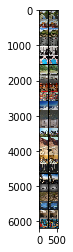

[Epoch 1/200] [Batch 837/1563]  [G loss: -0.710115] [L1 loss: 0.038080] [l2 loss: 0.004715] [SSIM: -0.752911]


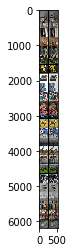

[Epoch 1/200] [Batch 1037/1563]  [G loss: -0.711247] [L1 loss: 0.037926] [l2 loss: 0.004702] [SSIM: -0.753875]


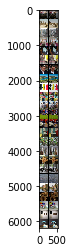

[Epoch 1/200] [Batch 1237/1563]  [G loss: -0.711213] [L1 loss: 0.037789] [l2 loss: 0.004692] [SSIM: -0.753694]


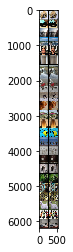

[Epoch 1/200] [Batch 1437/1563]  [G loss: -0.705950] [L1 loss: 0.038481] [l2 loss: 0.004853] [SSIM: -0.749283]


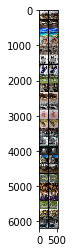

[Epoch 2/200] [Batch 74/1563]  [G loss: -0.702794] [L1 loss: 0.039164] [l2 loss: 0.004955] [SSIM: -0.746913]


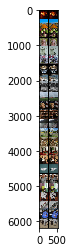

[Epoch 2/200] [Batch 274/1563]  [G loss: -0.708909] [L1 loss: 0.038351] [l2 loss: 0.004791] [SSIM: -0.752051]


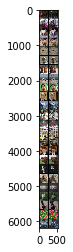

[Epoch 2/200] [Batch 474/1563]  [G loss: -0.710321] [L1 loss: 0.038050] [l2 loss: 0.004759] [SSIM: -0.753130]


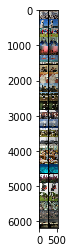

[Epoch 2/200] [Batch 674/1563]  [G loss: -0.709762] [L1 loss: 0.038018] [l2 loss: 0.004725] [SSIM: -0.752506]


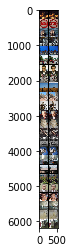

[Epoch 2/200] [Batch 874/1563]  [G loss: -0.708659] [L1 loss: 0.038236] [l2 loss: 0.004749] [SSIM: -0.751644]


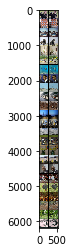

[Epoch 2/200] [Batch 1074/1563]  [G loss: -0.715221] [L1 loss: 0.037401] [l2 loss: 0.004628] [SSIM: -0.757250]


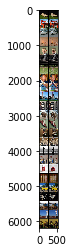

[Epoch 2/200] [Batch 1274/1563]  [G loss: -0.706873] [L1 loss: 0.038560] [l2 loss: 0.004833] [SSIM: -0.750265]


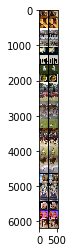

[Epoch 2/200] [Batch 1474/1563]  [G loss: -0.710520] [L1 loss: 0.038012] [l2 loss: 0.004712] [SSIM: -0.753243]


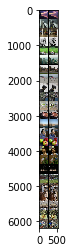

[Epoch 3/200] [Batch 111/1563]  [G loss: -0.707801] [L1 loss: 0.038511] [l2 loss: 0.004875] [SSIM: -0.751186]


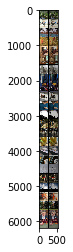

[Epoch 3/200] [Batch 311/1563]  [G loss: -0.714983] [L1 loss: 0.037176] [l2 loss: 0.004526] [SSIM: -0.756685]


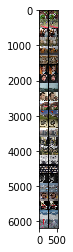

[Epoch 3/200] [Batch 511/1563]  [G loss: -0.710900] [L1 loss: 0.038223] [l2 loss: 0.004832] [SSIM: -0.753955]


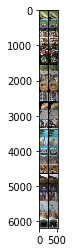

[Epoch 3/200] [Batch 711/1563]  [G loss: -0.711348] [L1 loss: 0.037853] [l2 loss: 0.004710] [SSIM: -0.753911]


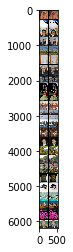

[Epoch 3/200] [Batch 911/1563]  [G loss: -0.708308] [L1 loss: 0.038289] [l2 loss: 0.004814] [SSIM: -0.751410]


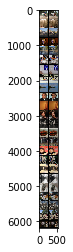

[Epoch 3/200] [Batch 1111/1563]  [G loss: -0.709510] [L1 loss: 0.038062] [l2 loss: 0.004730] [SSIM: -0.752302]


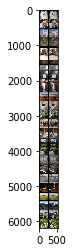

[Epoch 3/200] [Batch 1311/1563]  [G loss: -0.708891] [L1 loss: 0.038289] [l2 loss: 0.004765] [SSIM: -0.751945]


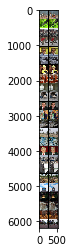

[Epoch 3/200] [Batch 1511/1563]  [G loss: -0.707572] [L1 loss: 0.038105] [l2 loss: 0.004730] [SSIM: -0.750407]


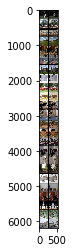

[Epoch 4/200] [Batch 148/1563]  [G loss: -0.710453] [L1 loss: 0.038097] [l2 loss: 0.004747] [SSIM: -0.753297]


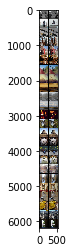

[Epoch 4/200] [Batch 348/1563]  [G loss: -0.714486] [L1 loss: 0.037466] [l2 loss: 0.004625] [SSIM: -0.756576]


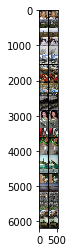

[Epoch 4/200] [Batch 548/1563]  [G loss: -0.706073] [L1 loss: 0.038637] [l2 loss: 0.004816] [SSIM: -0.749526]


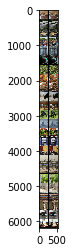

[Epoch 4/200] [Batch 748/1563]  [G loss: -0.710204] [L1 loss: 0.037898] [l2 loss: 0.004714] [SSIM: -0.752815]


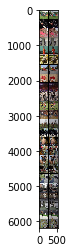

[Epoch 4/200] [Batch 948/1563]  [G loss: -0.710615] [L1 loss: 0.038151] [l2 loss: 0.004768] [SSIM: -0.753534]


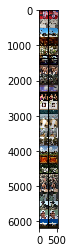

[Epoch 4/200] [Batch 1148/1563]  [G loss: -0.711760] [L1 loss: 0.037851] [l2 loss: 0.004730] [SSIM: -0.754341]


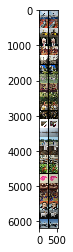

[Epoch 4/200] [Batch 1348/1563]  [G loss: -0.708482] [L1 loss: 0.038198] [l2 loss: 0.004794] [SSIM: -0.751475]


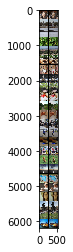

[Epoch 4/200] [Batch 1548/1563]  [G loss: -0.708072] [L1 loss: 0.038247] [l2 loss: 0.004753] [SSIM: -0.751071]


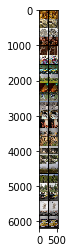

[Epoch 5/200] [Batch 185/1563]  [G loss: -0.709299] [L1 loss: 0.038071] [l2 loss: 0.004729] [SSIM: -0.752098]


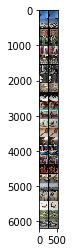

[Epoch 5/200] [Batch 385/1563]  [G loss: -0.711041] [L1 loss: 0.037878] [l2 loss: 0.004699] [SSIM: -0.753618]


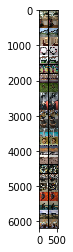

[Epoch 5/200] [Batch 585/1563]  [G loss: -0.710363] [L1 loss: 0.038212] [l2 loss: 0.004788] [SSIM: -0.753364]


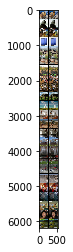

[Epoch 5/200] [Batch 785/1563]  [G loss: -0.710100] [L1 loss: 0.038004] [l2 loss: 0.004732] [SSIM: -0.752836]


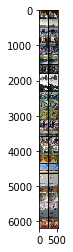

[Epoch 5/200] [Batch 985/1563]  [G loss: -0.710886] [L1 loss: 0.038389] [l2 loss: 0.004753] [SSIM: -0.754028]


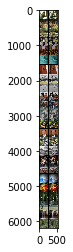

[Epoch 5/200] [Batch 1185/1563]  [G loss: -0.708956] [L1 loss: 0.038180] [l2 loss: 0.004780] [SSIM: -0.751916]


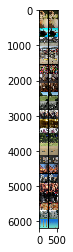

[Epoch 5/200] [Batch 1385/1563]  [G loss: -0.709384] [L1 loss: 0.038121] [l2 loss: 0.004765] [SSIM: -0.752269]


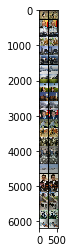

[Epoch 6/200] [Batch 22/1563]  [G loss: -0.703905] [L1 loss: 0.038002] [l2 loss: 0.004735] [SSIM: -0.746642]


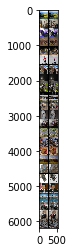

[Epoch 6/200] [Batch 222/1563]  [G loss: -0.714599] [L1 loss: 0.037338] [l2 loss: 0.004625] [SSIM: -0.756562]


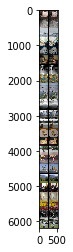

In [0]:
# ----------
#  Training
# ----------
std_1= Tensor(std).unsqueeze(0).unsqueeze(2).unsqueeze(3)
mean_1= Tensor(mean).unsqueeze(0).unsqueeze(2).unsqueeze(3) 
class ImageDataset(Dataset):
    def __init__(self, root, hr_shape):
        hr_height, hr_width = hr_shape
        # Transforms for low resolution images and high resolution images
        self.lr_transform = transforms.Compose(
            [
                transforms.Resize((hr_height // 4, hr_height // 4)),
                transforms.ToTensor(),
                #transforms.Normalize(mean, std),
            ]
        )
        self.hr_transform = transforms.Compose(
            [
                transforms.Resize((hr_height, hr_height)),
                transforms.ToTensor(),
                #transforms.Normalize(mean, std),
            ]
        )
        
        self.hr_transform_norm = transforms.Compose(
            [
                transforms.Resize((hr_height, hr_height)),
                transforms.ToTensor(),
                transforms.Normalize(mean, std),
            ]
        )

        self.files = sorted(glob.glob(root + "/*.*"))

    def __getitem__(self, index):
        img = Image.open(self.files[index % len(self.files)])
        img_lr = self.lr_transform(img)
        img_hr = self.hr_transform(img)
        img_hr_norm = self.hr_transform_norm(img)
        return {"lr": img_lr, "hr": img_hr, "hr_norm": img_hr_norm}

    def __len__(self):
        return len(self.files)
      

dataloader = DataLoader(
    ImageDataset("/data/256x256", hr_shape=hr_shape),
    batch_size=batch_size,
    shuffle=True,
    num_workers=4
)  

for epoch in range(epochs):
    if epoch % checkpoint_interval == 0:
        # Save model checkpoints
          torch.save(generator.state_dict(), "/content/drive/My Drive/DL/ckpt_1/generator_%d.pth" % epoch)
          torch.save(discriminator.state_dict(), "/content/drive/My Drive/DL/ckpt_1/discriminator_%d.pth" % epoch)

    avg_l1 = []
    avg_g = []
    avg_ssim = []
    avg_l2 = []
    for i, imgs in enumerate(dataloader):
        
        # Configure model input
        imgs_lr = Variable(imgs["lr"].type(Tensor))
        imgs_hr = Variable(imgs["hr"].type(Tensor))
        imgs_hr_norm = Variable(imgs["hr_norm"].type(Tensor))
        # ------------------
        #  Train Generators
        # ------------------
        optimizer_G.zero_grad()

        # Generate a high resolution image from low resolution input
        
        gen_hr = generator(imgs_lr)

        # Content loss
        gen_hr_norm = (gen_hr-mean_1)/std_1
        gen_features = feature_extractor(gen_hr_norm)
        real_features = feature_extractor(imgs_hr_norm)
        loss_l1 = criterion_L1(gen_features, real_features.detach())
        loss_ssim = -1*criterion_SSIM(gen_hr, imgs_hr)
        loss_img = criterion_L1(gen_hr, imgs_hr)
        loss_img_l2 = criterion_L2(gen_hr, imgs_hr)
        # Total loss
        loss_G =  loss_img + loss_img_l2+loss_ssim + loss_l1
        loss_G.backward()
        optimizer_G.step()
        avg_l1.append(loss_img.item())
        avg_l2.append(loss_img_l2.item())
        avg_ssim.append(loss_ssim.item())
        avg_g.append(loss_G.item())
      
        # --------------
        #  Log Progress
        # --------------

  
        batches_done = epoch * len(dataloader) + i
        if batches_done % 200 == 0:
            sys.stdout.write(
            "[Epoch %d/%d] [Batch %d/%d]  [G loss: %f] [L1 loss: %f] [l2 loss: %f] [SSIM: %f]\n"
            % (epoch, epochs, i, len(dataloader), np.array(avg_g).mean(), np.array(avg_l1).mean(), np.array(avg_l2).mean(), np.array(avg_ssim).mean())
        )

            # Save image grid with upsampled inputs and SRGAN outputs
            avg_g = []
            avg_l1 = []
            avg_l2 = []
            avg_ssim = []
            imgs_lr = nn.functional.interpolate(imgs_lr, scale_factor=4)
            gen_hr = make_grid(gen_hr, nrow=1, normalize=True)
            imgs_lr = make_grid(imgs_lr, nrow=1, normalize=True)
            img_grid = torch.cat((imgs_lr, gen_hr), -1)
            import matplotlib.pyplot as plt
            image = np.moveaxis(img_grid.detach().cpu().numpy(),0,-1)
            plt.imshow(image)
            plt.show()
             
    if epoch % checkpoint_interval == 0:
        # Save model checkpoints
        torch.save(generator.state_dict(), "/content/drive/My Drive/DL/ckpt_1/generator_%d.pth" % epoch)
        torch.save(discriminator.state_dict(), "/content/drive/My Drive/DL/ckpt_1/discriminator_%d.pth" % epoch)
